In [1]:
from pygraphblas import *
from time import time
import random
from pygraphblas.gviz import draw

from collections import defaultdict
from itertools import groupby
from operator import itemgetter

def group_labels(T):
    d = defaultdict(list)
    for k,v in groupby(T, itemgetter(1)):
        d[k].append(list(v)[0][0])
    return d

def compare_groups(left, right):
    left = {k: set(v) for k, v in left.items()}
    right = {k: set(v) for k, v in right.items()}
    return sorted(left.values()) == sorted(right.values())

def get_louvain_cluster_assignments(cluster_matrix):
    return cluster_matrix.cast(INT64).apply(INT64.POSITIONJ).reduce_vector()


In [2]:
I = [0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5, 5,
    6, 6, 6,
    7, 7, 7, 7]

J = [0, 2, 3, 6,
    1, 2, 3, 7,
    0, 2, 4, 6,
    0, 1, 3, 5,
    0, 2, 4, 6,
    1, 3, 5, 6, 7,
    0, 4, 6,
    1, 3, 5, 7]

M = Matrix.from_lists(I, J, [1.0] * len(I), typ=FP64)

In [8]:
def louvain_cluster(A, max_iters=10):
    S = Matrix.identity(BOOL, A.nrows)
    empty = Vector.sparse(BOOL, A.nrows)
    i = 0
    changed = True
    
    start = time()
    AT = A.T + A
    k = A.reduce_vector()
    m = k.reduce_int() / 2.0
    nkm = (-k) / m
    while changed and i < max_iters:
        changed = False
        for j in set(k.indexes):
            Sj = S[j]
            S[j] = empty
            v = AT[j] + nkm[j]
            q = v @ S
            t = q.select('==', q.reduce_float(FP64.MAX_MONOID))
            if t:
                r = random.choice(list(t.indexes))
                S[j, r] = True
                if Sj.get(r) is None:
                    changed = True
        i += 1
    print(f'Input size {len(A)} {i} iterations took {time() - start}')
    return S

Input size 32 3 iterations took 0.0041506290435791016


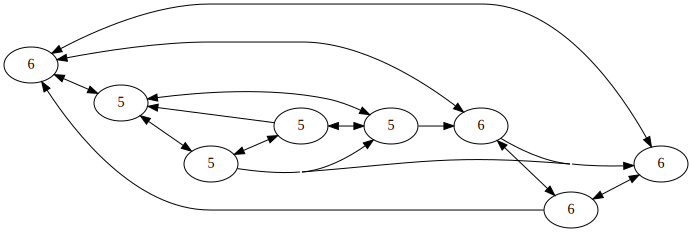

In [4]:
ans = louvain_cluster(M, 5)
random.seed(33)
labels = get_louvain_cluster_assignments(ans)
draw(M.offdiag(), show_weight=False, label_vector=labels)

In [9]:
sizes = [(10, 5000), (10, 20000)]

random.seed(46)
for iters, size in sizes:
    data = Matrix.from_tsv('louvain_data/simulated_blockmodel_graph_%s_nodes.tsv' % size, FP64, size, size)
    print('Loaded', size, 'nodes.')
    ans = louvain_cluster(data, max_iters=iters)
    assignments = get_louvain_cluster_assignments(ans)
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes_truePartition.tsv' % size) as truth:
        T = Vector.sparse(UINT8, size)
        for line in truth:
            i, j = map(int, line.split('\t'))
            T[i-1] = j
    print(size, 'Correct?', compare_groups(group_labels(assignments), group_labels(T)))
    

Loaded 5000 nodes.
Input size 101973 4 iterations took 5.162307500839233
5000 Correct? True
Loaded 20000 nodes.
Input size 408778 4 iterations took 41.30300498008728
20000 Correct? True


In [6]:
import community
import networkx as nx
from time import time

name = lambda v: "louvain_data/simulated_blockmodel_graph_{}_nodes".format(v)

def make_dict(tup):
    trued = {}
    for n,c in tup:
        trued.setdefault(c, []).append(n)
    trued = { tuple(trued[c]):c for c in trued }
    return trued

def get_nodes_comm(name):
    with open(name + "_truePartition.tsv", "r") as f:
        truep = [tuple(map(int, l.split('\t'))) for l in f]

    G = nx.read_edgelist(name + ".tsv", delimiter='\t', data=(('weight', float),), create_using=nx.DiGraph())
    start = time()
    partition = community.best_partition(G.to_undirected())
    print(name, 'took', time() - start)
    pl = [ (int(n), c) for n,c in list(partition.items()) ]
    pl.sort()
    return make_dict(truep), make_dict(pl)

In [7]:
for numv in [5000, 20000]:
    trued, pd = get_nodes_comm(name(numv))

louvain_data/simulated_blockmodel_graph_5000_nodes took 2.027055025100708
louvain_data/simulated_blockmodel_graph_20000_nodes took 13.771668195724487
